In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('SEntFiN.csv')
label_column = df['Decisions']

In [3]:
# filter, only keep headlines with 1 sentiment label
df = df[~df['Decisions'].str.contains(',', na=False)]
df

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,{'SpiceJet': 'neutral'},8
1,2,MMTC Q2 net loss at Rs 10.4 crore,{'MMTC': 'neutral'},8
2,3,"Mid-cap funds can deliver more, stay put: Experts",{'Mid-cap funds': 'positive'},8
3,4,Mid caps now turn into market darlings,{'Mid caps': 'positive'},7
4,5,"Market seeing patience, if not conviction: Pra...",{'Market': 'neutral'},8
...,...,...,...,...
10697,10698,Vedanta-Cairn deal may not go through: Ajay Bagga,{'Vedanta-Cairn': 'negative'},8
10700,10701,"Wall Street opens flat, S&P 500 near record",{'Wall Street': 'neutral'},8
10710,10711,"Heard on the street: Dutchman MF, FIIs",{'Dutchman MF': 'neutral'},7
10714,10715,Rebound for Russia and China lifts stocks,{'stocks': 'positive'},7


# Data Transformation

In [4]:
# modify 'Decisions' column to only keep sentiment labels without entities

def modifyLabel(x):
    if 'neutral' in x:
        x = 'neutral'
    elif 'positive' in x:
        x = 'positive'
    else:
        x = 'negative'
    return x

new_label_column = label_column.apply(modifyLabel)

df['Decisions'] = new_label_column

df.head()

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,neutral,8
1,2,MMTC Q2 net loss at Rs 10.4 crore,neutral,8
2,3,"Mid-cap funds can deliver more, stay put: Experts",positive,8
3,4,Mid caps now turn into market darlings,positive,7
4,5,"Market seeing patience, if not conviction: Pra...",neutral,8


# Data Splitting

In [22]:
# Convert strings (headlines) into TF-IDF vectors

vectorizer = TfidfVectorizer()
vectorizer.fit(df['Title'])
X = vectorizer.transform(df['Title'])
x=df['Title']

y = df['Decisions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)
# train,test=train_test_split(df, test_size = 0.2, random_state=42)
# train.to_csv('train.csv', index=False)
# test.to_csv('test.csv',index=False)



# Naive Bayes Classifier 

0.740506329113924


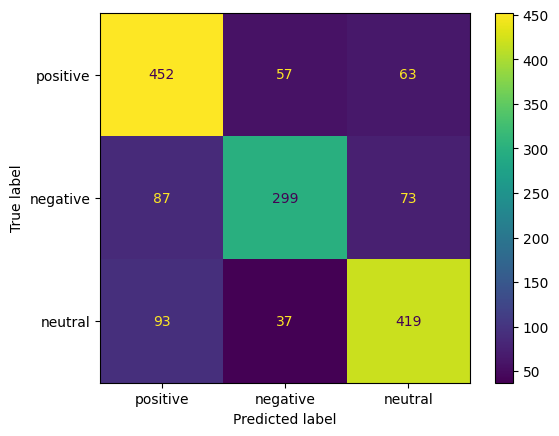

Classification Report: 
              precision    recall  f1-score   support

    negative       0.76      0.65      0.70       459
     neutral       0.75      0.76      0.76       549
    positive       0.72      0.79      0.75       572

    accuracy                           0.74      1580
   macro avg       0.74      0.73      0.74      1580
weighted avg       0.74      0.74      0.74      1580
 

Mean accuracy: 0.76
Best accuracy from the best fold: 0.81


In [23]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['positive','negative','neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive','negative','neutral'])
disp.plot()
plt.show()
print("Classification Report: ")
print(classification_report(y_test,y_pred), "\n")

#10-Fold Cross-Validation
nb_cv = cross_val_score(model, X,y,cv=10, scoring='accuracy')
print(f"Mean accuracy: {nb_cv.mean():.2f}")
best_accuracy = max(nb_cv)
print(f"Best accuracy from the best fold: {best_accuracy:.2f}")


# Support Vector Classifier

In [24]:
param_grid = {
    'C': [0.1, 1, 10, 100],         # Regularization strength
    'kernel': ['linear', 'rbf','sigmoid'],    # Linear and Radial Basis Function kernels
    'gamma': [0.01, 0.1, 1, 10,'scale','auto']     # Defines the influence of a single training example. The higher the value, the closer other points must be to be affected.
}

svm = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    scoring='accuracy',   # Optimize for accuracy
    cv=3,                 # 7-fold cross-validation
    verbose=1,            # Print progress
    n_jobs=-1             # Use all CPU cores
)

svm.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 10, 'scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [25]:
print("Best parameters:", svm.best_params_)
print("Best cross-validation score:", svm.best_score_)

# Evaluate the best model on the test set
best_model = svm.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test set accuracy:", test_accuracy)

Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.8017412225607131
Test set accuracy: 0.8063291139240506


In [34]:
model=SVC(C=10,kernel='rbf',gamma=1)
model.fit(X_train,y_train)
predictions = model.predict(X_test)


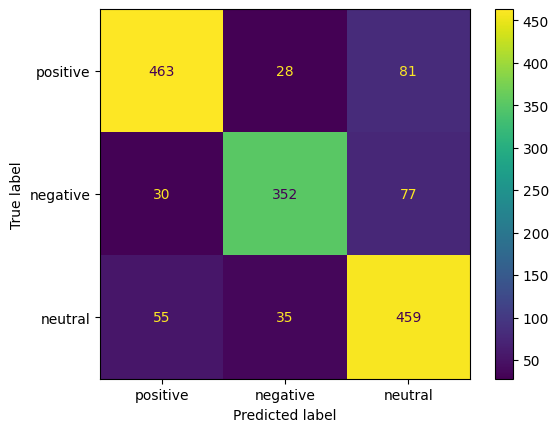

Accuracy Score:
0.8063291139240506 

Classification Report: 
              precision    recall  f1-score   support

    negative       0.85      0.77      0.81       459
     neutral       0.74      0.84      0.79       549
    positive       0.84      0.81      0.83       572

    accuracy                           0.81      1580
   macro avg       0.81      0.80      0.81      1580
weighted avg       0.81      0.81      0.81      1580
 



In [10]:
cm = confusion_matrix(y_test, predictions, labels=['positive','negative','neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive','negative','neutral'])
disp.plot()
plt.show()

print("Accuracy Score:")
print(accuracy_score(y_test, predictions), "\n")

# print("Confusion Matrix: ")
# print(confusion_matrix(y_test,predictions), "\n")

print("Classification Report: ")
print(classification_report(y_test,predictions), "\n")

# Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

In [14]:
# Hyperparameter tuning for Random Forest Classifier

n_estimators = [50, 100, 200]
max_depth = [10, 20, None]
min_samples_split = [2, 5]

param_grid = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split}

rf_Grid = GridSearchCV(estimator = model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

rf_Grid.fit(X_train, y_train)

rf_Grid.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

In [15]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=5, random_state=10)
model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=200, random_state=10)

In [16]:
predictions = model.predict(X_test)

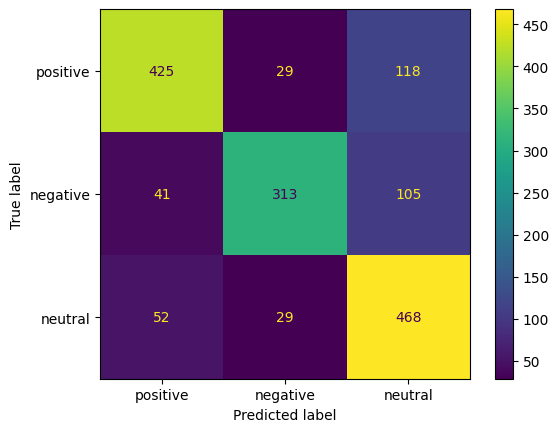

Accuracy Score:
0.7632911392405063 

Classification Report: 
              precision    recall  f1-score   support

    negative       0.84      0.68      0.75       459
     neutral       0.68      0.85      0.75       549
    positive       0.82      0.74      0.78       572

    accuracy                           0.76      1580
   macro avg       0.78      0.76      0.76      1580
weighted avg       0.78      0.76      0.76      1580
 



In [ ]:
cm = confusion_matrix(y_test, predictions, labels=['positive','negative','neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive','negative','neutral'])
disp.plot()
plt.show()

print("Accuracy Score:")
print(accuracy_score(y_test, predictions), "\n")


print("Classification Report: ")
print(classification_report(y_test,predictions), "\n")

# DistilBERT


In [39]:
from transformers import  AutoModelForSequenceClassification, AutoTokenizer
checkpoint = "distilbert-base-uncased" # Define which pre-trained model we will be using
classifier = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3) # Get the classifier
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # Get the tokenizer

C:\Users\baong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
mapping = {'positive': 2, 'negative': 1, 'neutral': 0}
df['Decisions'] = df['Decisions'].map(mapping)

In [41]:
# To make this simple we will drop id, keyword, location and only keep text and target
df = df.loc[:,["Title", "Decisions"]]
df


,Title,Decisions
0,SpiceJet to issue 6.4 crore warrants to promoters,0
1,MMTC Q2 net loss at Rs 10.4 crore,0
2,"Mid-cap funds can deliver more, stay put: Experts",2
3,Mid caps now turn into market darlings,2
4,"Market seeing patience, if not conviction: Pra...",0
...,...,...
10697,Vedanta-Cairn deal may not go through: Ajay Bagga,1
10700,"Wall Street opens flat, S&P 500 near record",0
10710,"Heard on the street: Dutchman MF, FIIs",0
10714,Rebound for Russia and China lifts stocks,2


In [42]:
# Split the data into train and evaluation (stratified)
df_train, df_eval = train_test_split(df, train_size=0.8,stratify=df.Decisions, random_state=42) # Stratified splitting 

In [43]:
from datasets import Dataset, DatasetDict
raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "eval": Dataset.from_pandas(df_eval)
})

In [44]:
# Check the datasets
print("Dataset Dict:\n", raw_datasets)
print("\n\nTrain's features:\n", raw_datasets["train"].features)
print("\n\nFirst row of Train:\n", raw_datasets["train"][0])

Dataset Dict:
 DatasetDict({
    train: Dataset({
        features: ['Title', 'Decisions', '__index_level_0__'],
        num_rows: 6320
    })
    eval: Dataset({
        features: ['Title', 'Decisions', '__index_level_0__'],
        num_rows: 1580
    })
})


Train's features:
 {'Title': Value(dtype='string', id=None), 'Decisions': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None)}


First row of Train:
 {'Title': "GVK's net loss shrinks to Rs 45 crore in Q3", 'Decisions': 2, '__index_level_0__': 2275}


In [45]:
# Tokenize the text, and truncate the text if it exceed the tokenizer maximum length. Batched=True to tokenize multiple texts at the same time.
tokenized_datasets = raw_datasets.map(lambda dataset: tokenizer(dataset['Title'], truncation=True,padding=True), batched=True)
print(tokenized_datasets)

Map: 100%|██████████| 1580/1580 [00:00<00:00, 3158.74 examples/s]

DatasetDict({
    train: Dataset({
        features: ['Title', 'Decisions', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 6320
    })
    eval: Dataset({
        features: ['Title', 'Decisions', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1580
    })
})


In [46]:
# Check the first row
print(tokenized_datasets["train"][0])

{'Title': "GVK's net loss shrinks to Rs 45 crore in Q3", 'Decisions': 2, '__index_level_0__': 2275, 'input_ids': [101, 1043, 2615, 2243, 1005, 1055, 5658, 3279, 22802, 2015, 2000, 12667, 3429, 21665, 1999, 1053, 2509, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [47]:
tokenized_datasets = tokenized_datasets.remove_columns(["Title", "__index_level_0__"])
tokenized_datasets = tokenized_datasets.rename_column("Decisions", "labels")
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6320
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1580
    })
})


In [53]:
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
import numpy as np
import evaluate

# Padding for batch of data that will be fed into model for training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training args 
training_args = TrainingArguments("test-trainer", num_train_epochs=1, evaluation_strategy="epoch", 
                                  weight_decay=5e-4, save_strategy="no", report_to="none")

# Metric for validation error
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mnli") # F1 and Accuracy for multi-class classification
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Define trainer
trainer = Trainer(
    classifier,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\baong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\baong\AppData\Local\Temp\ipykernel_30400\2714762132.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [54]:
# Start the fine-tuning 

trainer.train()

                                                   
 94%|█████████▍| 1483/1580 [28:36<01:07,  1.43it/s]

{'loss': 0.1226, 'grad_norm': 7.946052551269531, 'learning_rate': 1.8354430379746836e-05, 'epoch': 0.63}










































































































































































































                                                   
                                              
 94%|█████████▍| 1483/1580 [36:07<01:07,  1.43it/s]
                                                   
100%|██████████| 790/790 [18:14<00:00,  1.38s/it]s]

{'eval_loss': 0.797224223613739, 'eval_accuracy': 0.8626582278481013, 'eval_runtime': 57.7244, 'eval_samples_per_second': 27.371, 'eval_steps_per_second': 3.43, 'epoch': 1.0}
{'train_runtime': 1094.1196, 'train_samples_per_second': 5.776, 'train_steps_per_second': 0.722, 'train_loss': 0.11532888533193854, 'epoch': 1.0}


TrainOutput(global_step=790, training_loss=0.11532888533193854, metrics={'train_runtime': 1094.1196, 'train_samples_per_second': 5.776, 'train_steps_per_second': 0.722, 'total_flos': 58307393250720.0, 'train_loss': 0.11532888533193854, 'epoch': 1.0})

In [55]:
from sklearn.metrics import classification_report

# Make prediction on evaluation dataset
y_pred = trainer.predict(tokenized_datasets["eval"]).predictions
y_pred = np.argmax(y_pred, axis=-1)

# Get the true labels
y_true = tokenized_datasets["eval"]["labels"]
y_true = np.array(y_true)

# Print the classification report
print(classification_report(y_true, y_pred, digits=3))

100%|██████████| 198/198 [00:25<00:00,  7.65it/s]

              precision    recall  f1-score   support

           0      0.887     0.774     0.827       540
           1      0.876     0.895     0.885       474
           2      0.834     0.920     0.875       566

    accuracy                          0.863      1580
   macro avg      0.866     0.863     0.862      1580
weighted avg      0.865     0.863     0.862      1580



[0 2 2 ... 1 2 1]
[0 2 2 ... 1 2 1]


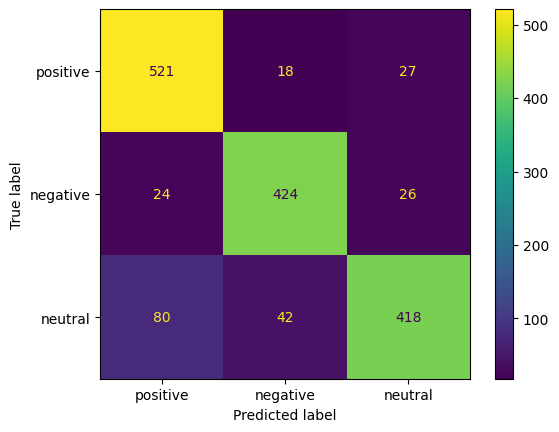

In [56]:
print(y_true)
print(y_pred)
cm = confusion_matrix(y_true, y_pred,labels=[2,1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive','negative','neutral'])
disp.plot()
plt.show()

In [45]:
# Get the test data
df_test = pd.read_csv("nasdaq.csv")
mapping = {1: 2, 0: 1, 2: 0}
y_true=df_test['Label'].tolist()
df_test['Label'] = df_test['Label'].map(mapping)
df_test['id'] = range(0, len(df_test))
df_test.head()

,Label,Ticker,Headline,id
0,1,A,@TotesTravel : Airline shares tumble as New Yo...,0
1,2,A,@TotesTravel : American United call off Hong K...,1
2,1,A,@TotesTravel : U.S. airline stocks hit highest...,2
3,2,A,@TotesTravel : American Airlines reaches deal ...,3
4,2,A,@TotesTravel : US airlines Treasury Department...,4


In [ ]:
# test model on a new dataset
ids = df_test.id # Save ids
df_test = df_test.loc[:,["Headline"]] # Keep only text

# Turn the DataFrame into appropriate format
test_dataset = Dataset.from_pandas(df_test)
test_dataset = test_dataset.map(lambda dataset: tokenizer(dataset['Headline'], truncation=True), batched=True)
test_dataset = test_dataset.remove_columns('Headline')

# Get the prediction
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

100%|██████████| 1648/1648 [07:02<00:00,  3.90it/s]


[1 0 2 ... 2 1 1]
              precision    recall  f1-score   support

           0      0.650     0.612     0.631      8565
           1      0.314     0.257     0.283      4300
           2      0.015     0.076     0.025       316

    accuracy                          0.484     13181
   macro avg      0.327     0.315     0.313     13181
weighted avg      0.526     0.484     0.503     13181



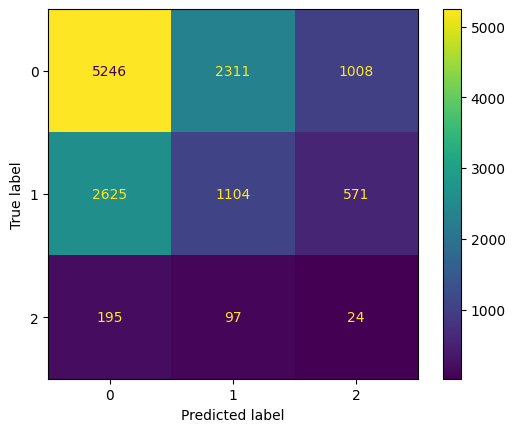

In [48]:
print(preds)
#print(y_true)
print(classification_report(y_true, preds, digits=3))

cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# FinBERT

In [ ]:
X = df['Title'].to_list()
y = df['Decisions'].to_list()

In [ ]:
# Import FinBERT model from Prosus AI

from transformers import BertTokenizer, BertForSequenceClassification, pipeline

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Load FinBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [ ]:
# Create a sentiment analysis pipeline
finbert_sentiment = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Predict sentiment
df["predicted_sentiment"] = df["Title"].apply(lambda x: finbert_sentiment(x)[0]["label"])

In [ ]:
# Compare predivctions with labels to calculate accuracy
df["correct"] = df["predicted_sentiment"] == df["Decisions"]
accuracy = df["correct"].mean()

print(df)
print(f"Accuracy: {accuracy:.2%}")

In [ ]:
wrongly_labeled = df[~df["correct"]][["Title", "predicted_sentiment", "Decisions"]]
wrongly_labeled

# FinBERT with training

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline, Trainer, TrainingArguments
from datasets import load_dataset
import evaluate

# Load FinBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert")

/Users/hpanh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hpanh/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Map string labels to integers
label_mapping = {"positive": 0, "neutral": 1, "negative": 2}
df["Decisions"] = df["Decisions"].map(label_mapping)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=10)

train_df.to_csv("train-finbert.csv", index=False)
test_df.to_csv("test-fibert.csv", index=False)

In [ ]:
dataset = load_dataset("csv", data_files={"train": "train.csv", "test": "test.csv"})

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["Title"], truncation=True, max_length=30, padding="max_length")

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("Decisions", "labels")
tokenized_datasets.set_format("torch")

In [ ]:
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",         # Directory for model checkpoints
    evaluation_strategy="epoch",    # Evaluate at each epoch
    learning_rate=2e-5,             # Learning rate
    per_device_train_batch_size=64, # Batch size
    per_device_eval_batch_size=64,  # Evaluation batch size
    num_train_epochs=4,             # Number of epochs
    warmup_steps=int(0.2 * len(tokenized_datasets["train"])), # Warm-up steps
    weight_decay=0.01,              # Weight decay
    logging_dir="./logs",           # Directory for logs
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
# Load metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)  # Get the predicted class indices

    # Compute metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

In [ ]:
results = trainer.evaluate()

print("Evaluation Results:", results)

In [ ]:
model.save_pretrained("./fine_tuned_finbert")
tokenizer.save_pretrained("./fine_tuned_finbert")